In [2]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
datas = []

for i in range(1, 80):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data= pd.concat(datas, ignore_index=True)

file not found:  /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_4.pkl
file not found:  /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_35.pkl


In [6]:
outsc = data[data.in_scluster == False]
insc =  data[data.in_scluster == True]

In [7]:
print("N in supercluster: ", len(insc))
print("N out supercluster: ", len(outsc))

N in supercluster:  467152
N out supercluster:  2335760


## Check plots

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.14159257e+00, -3.07876075e+00, -3.01592893e+00, -2.95309711e+00,
        -2.89026529e+00, -2.82743348e+00, -2.76460166e+00, -2.70176984e+00,
        -2.63893802e+00, -2.57610620e+00, -2.51327439e+00, -2.45044257e+00,
        -2.38761075e+00, -2.32477893e+00, -2.26194711e+00, -2.19911530e+00,
        -2.13628348e+00, -2.07345166e+00, -2.01061984e+00, -1.94778803e+00,
        -1.88495621e+00, -1.82212439e+00, -1.75929257e+00, -1.69646075e+00,
        -1.63362894e+00, -1.57079712e+00, -1.50796530e+00, -1.44513348e+00,
        -1.38230166e+00, -1.31946985e+00, -1.25663803e+00, -1.19380621e+00,
        -1.13097439e+00, -1.06814257e+00, -1.00531076e+00, -9.42478938e-01,
        -8.79647120e-01, -8.16815302e-01, -7.53983484e-01, -6.91151

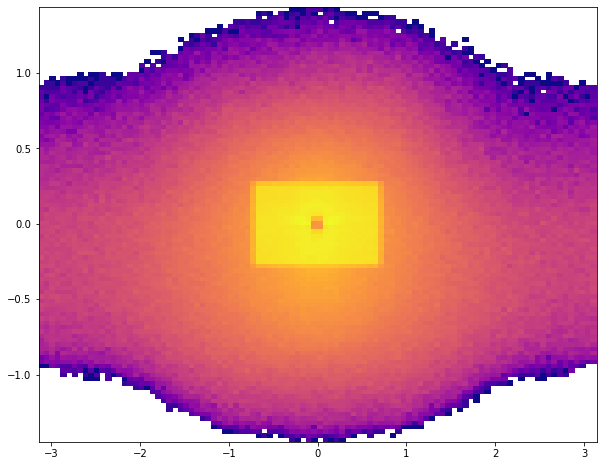

In [14]:
plt.hist2d(outsc.cluster_dphi, outsc.cluster_deta, 
           density=True, bins=(100,100),cmap="plasma", norm=colors.LogNorm())

## Weights by DeltaPhi

In [15]:
data.columns

Index(['cluster_deta', 'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed',
       'en_true', 'in_scluster', 'index', 'is_calo', 'is_seed',
       'max_dr_cluster', 'max_en_cluster', 'nclusters', 'seed_eta', 'seed_iz',
       'seed_phi', 'window_index'],
      dtype='object')

In [4]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [5]:
X = data[ cols ].values
truth = data[["in_scluster", "nclusters"]].values
y = np.array(truth[:,0], dtype=int)
#train_weights = data.train_weight.values

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open("models/scaler.pkl", "wb"))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [20]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [21]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train,  batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=1024, sampler=RandomOverSampler())

Using TensorFlow backend.


# Training

In [2]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


In [23]:
model = Sequential()
model.add(Dense(100, input_dim=7, activation="relu"))
model.add(Dropout(0.3))
#model.add(Dense(80, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

W1211 15:52:40.897570 139648409261888 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 15:52:40.926043 139648409261888 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 15:52:40.931446 139648409261888 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 15:52:40.955790 139648409261888 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x8

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
auto_save = ModelCheckpoint("models/model8_balanced.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                            patience=10, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=100,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [auto_save]
            )

Epoch 1/100
3649/3649 [==============================] - 18s 5ms/step - loss: 0.1252 - acc: 0.9534 - val_loss: 0.0813 - val_acc: 0.9712
Epoch 2/100
3649/3649 [==============================] - 19s 5ms/step - loss: 0.0890 - acc: 0.9686 - val_loss: 0.0755 - val_acc: 0.9728
Epoch 3/100
3649/3649 [==============================] - 19s 5ms/step - loss: 0.0849 - acc: 0.9700 - val_loss: 0.0730 - val_acc: 0.9734
Epoch 4/100
3649/3649 [==============================] - 17s 5ms/step - loss: 0.0828 - acc: 0.9706 - val_loss: 0.0720 - val_acc: 0.9738
Epoch 5/100
3649/3649 [==============================] - 18s 5ms/step - loss: 0.0817 - acc: 0.9711 - val_loss: 0.0707 - val_acc: 0.9741

Epoch 00005: val_loss improved from inf to 0.07069, saving model to models/model8_unbalanced.hd5
Epoch 6/100
3649/3649 [==============================] - 20s 6ms/step - loss: 0.0808 - acc: 0.9713 - val_loss: 0.0699 - val_acc: 0.9748
Epoch 7/100
3649/3649 [==============================] - 18s 5ms/step - loss: 0.0802 -

KeyboardInterrupt: 

In [21]:
history = model.fit(
            x = X_train, y = y_train, 
            epochs=200,
            batch_size = 1024, 
            shuffle=True, 
            validation_split=0.15, 
            callbacks = [auto_save, early_stop]
            )

Train on 817376 samples, validate on 144243 samples
Epoch 1/200
817376/817376 [==============================] - 5s 6us/step - loss: 0.3277 - acc: 0.8532 - val_loss: 0.2442 - val_acc: 0.8969
Epoch 2/200
817376/817376 [==============================] - 4s 5us/step - loss: 0.2529 - acc: 0.8936 - val_loss: 0.2310 - val_acc: 0.9028
Epoch 3/200
817376/817376 [==============================] - 4s 5us/step - loss: 0.2422 - acc: 0.8981 - val_loss: 0.2236 - val_acc: 0.9056

Epoch 00003: val_loss improved from inf to 0.22361, saving model to models/model5_balanced.hd5
Epoch 4/200
817376/817376 [==============================] - 5s 6us/step - loss: 0.2364 - acc: 0.9011 - val_loss: 0.2193 - val_acc: 0.9076
Epoch 5/200
817376/817376 [==============================] - 5s 6us/step - loss: 0.2320 - acc: 0.9027 - val_loss: 0.2159 - val_acc: 0.9093
Epoch 6/200
817376/817376 [==============================] - 5s 6us/step - loss: 0.2292 - acc: 0.9042 - val_loss: 0.2128 - val_acc: 0.9111
Epoch 7/200
817376

>>> Computing AUC...
AUC score: 0.9970550498502361
>>> Saving ROC curve...


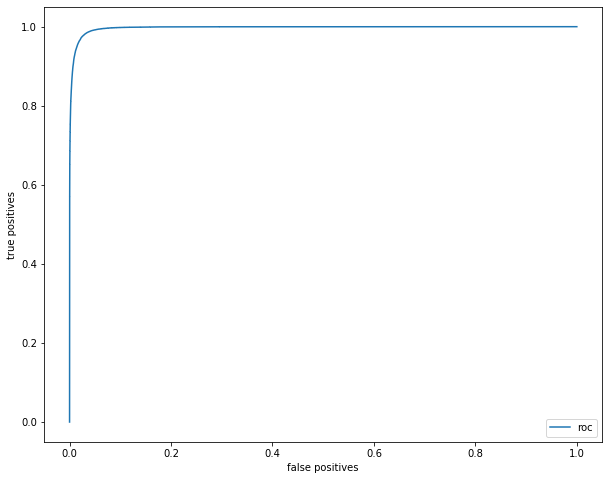

In [25]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

In [26]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

NameError: name 'history' is not defined

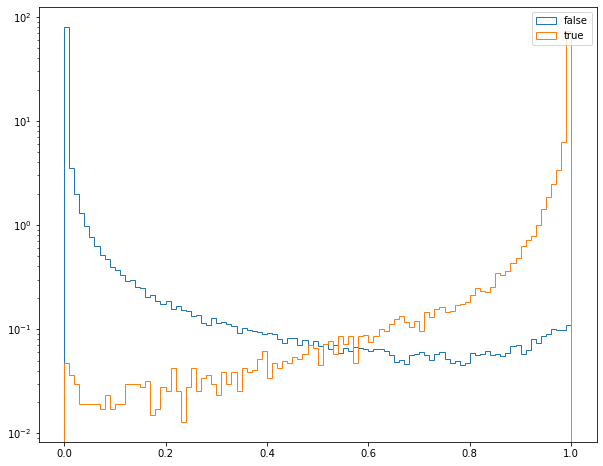

In [27]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Some plots

In [5]:
from keras.models import load_model
model = load_model("models/model8_balanced.hd5")

W1211 16:29:40.978582 140087247931200 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 16:29:41.025169 140087247931200 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 16:29:41.067199 140087247931200 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 16:29:41.068565 140087247931200 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x

In [28]:
datas_val = []

for i in range(80, 120):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_val.append(d[(d.is_calo) & (d.is_seed == False)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [31]:
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)

data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

>>> Computing AUC...
AUC score: 0.9969577623043515
>>> Saving ROC curve...


/usr/local/lib/swan/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/swan/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


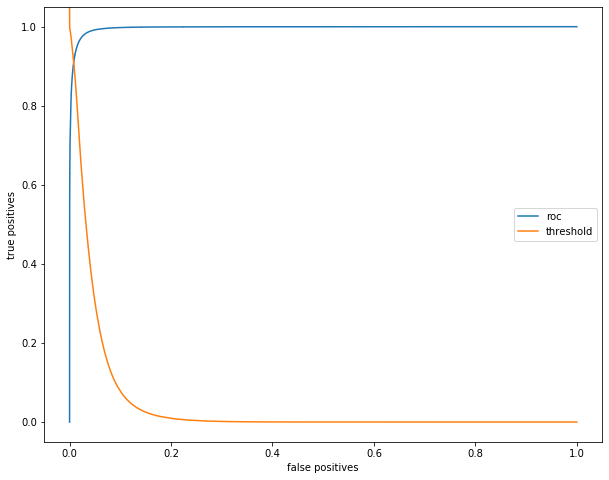

In [32]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred = data_val["y"].values
auc = roc_auc_score(y_test,pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

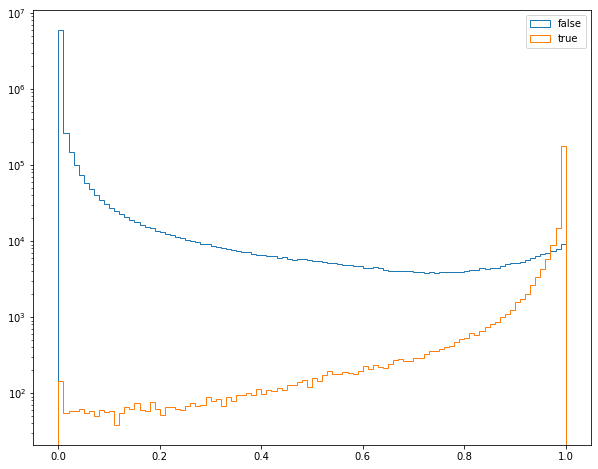

In [34]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [47]:
tr = 0.8
data_out_0 = data_out[data_out.y < tr]
data_out_1 = data_out[data_out.y > tr]
data_in_0 = data_in[data_in.y < tr]
data_in_1 = data_in[data_in.y > tr]

(-0.6, 0.6)

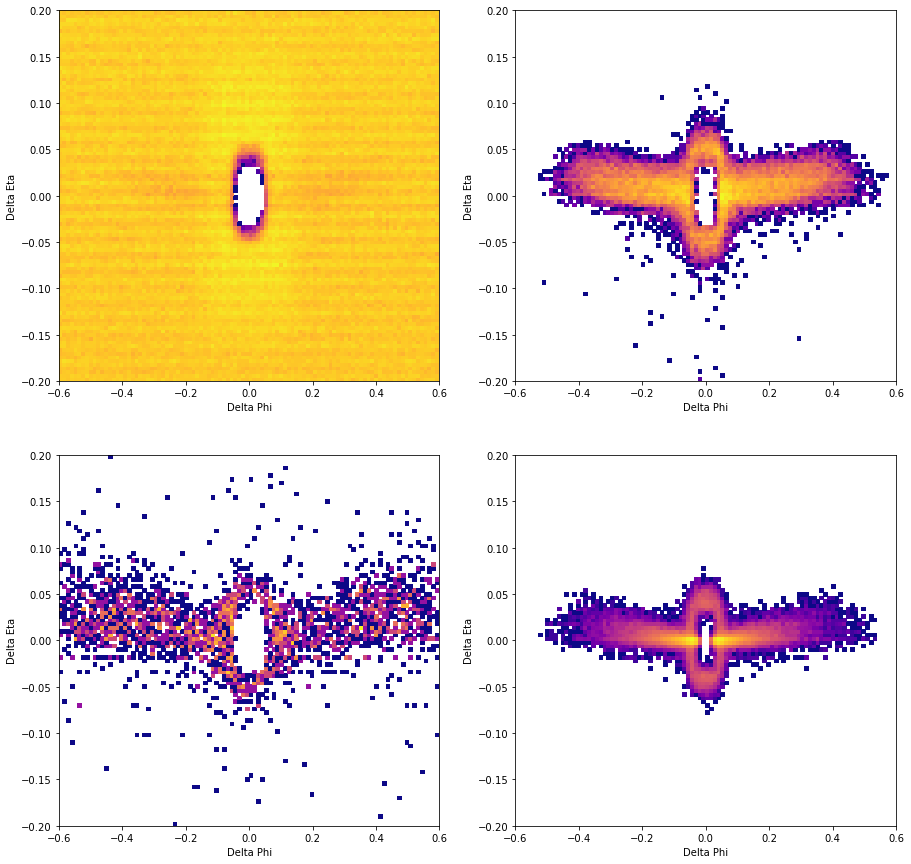

In [48]:
eta_min = 0
eta_max = 1
nbins = 100
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)

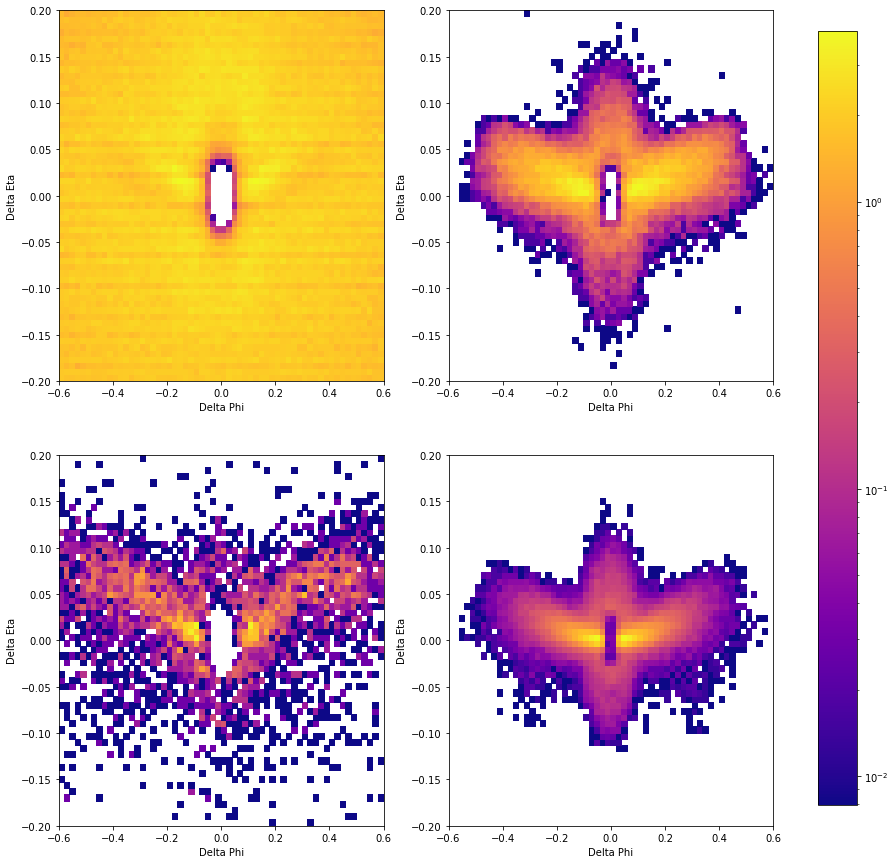

In [49]:
eta_min = 1
eta_max = 2
nbins = 60
fig, ax = plt.subplots(2,2, figsize=(16,15))
h2 = ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)

cbar = fig.colorbar(h2[-1], ax=ax.ravel().tolist(), shrink=0.95)

(-0.8, 0.8)

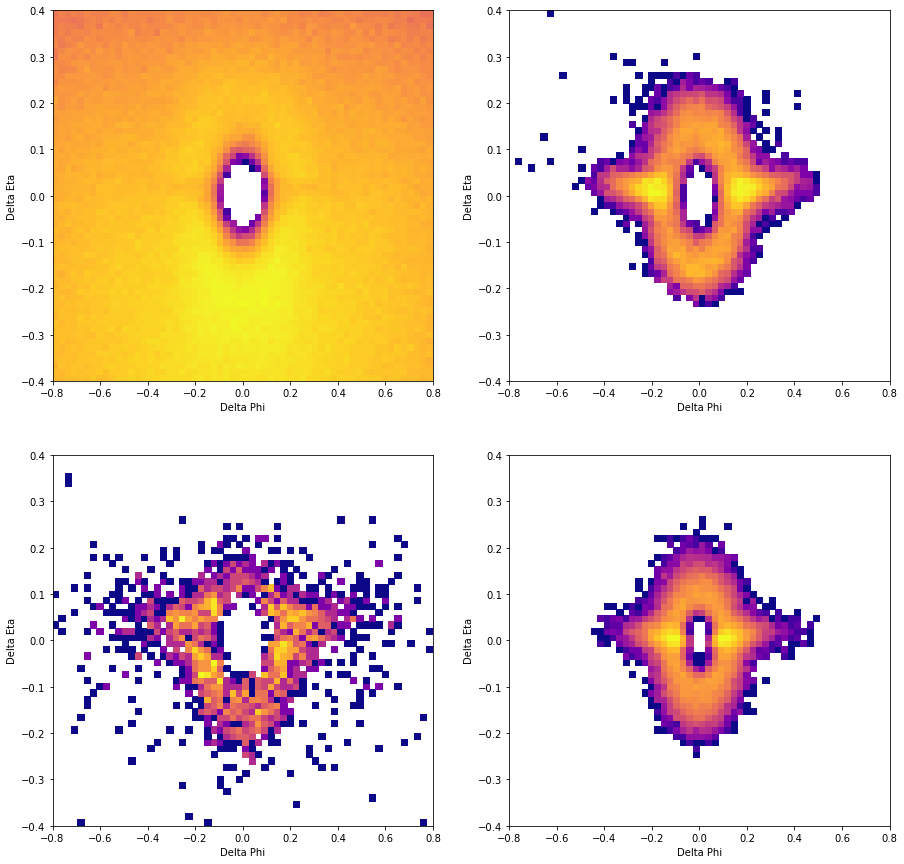

In [50]:
eta_min = 2
eta_max = 3
rg = ((-0.8,0.8),(-0.4,0.4))
nbins = 60
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=rg, cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=rg, cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=rg, cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=rg, cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.4, 0.4)
ax[1][0].set_xlim(-0.8,0.8)
ax[0][0].set_ylim(-0.4, 0.4)
ax[0][0].set_xlim(-0.8,0.8)
ax[1][1].set_ylim(-0.4, 0.4)
ax[1][1].set_xlim(-0.8,0.8)
ax[0][1].set_ylim(-0.4, 0.4)
ax[0][1].set_xlim(-0.8,0.8)

## energy resolution plot

In [45]:
datas_val = []

for i in range(80, 100):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_val.append(d[(d.is_calo)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [46]:
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)

data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

In [59]:
thresholds = [0.7,0.8,0.85,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', "en_true": "min"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

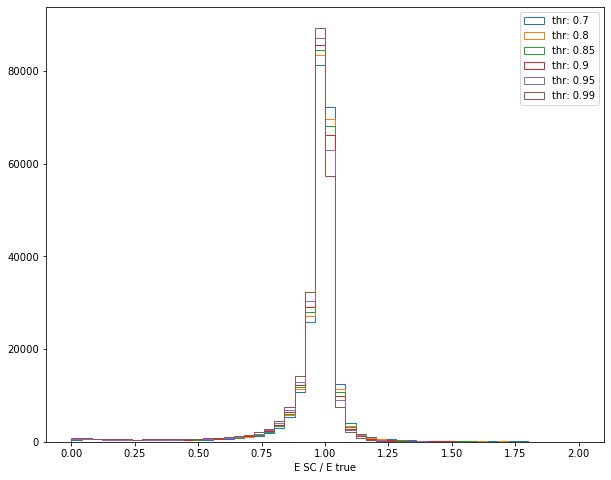

In [60]:
for t , g in results.items():
    plt.hist(g.ratio, range=(0,2), bins=50,  histtype="step", label=f"thr: {t}",)
plt.xlabel("E SC / E true")
plt.legend()

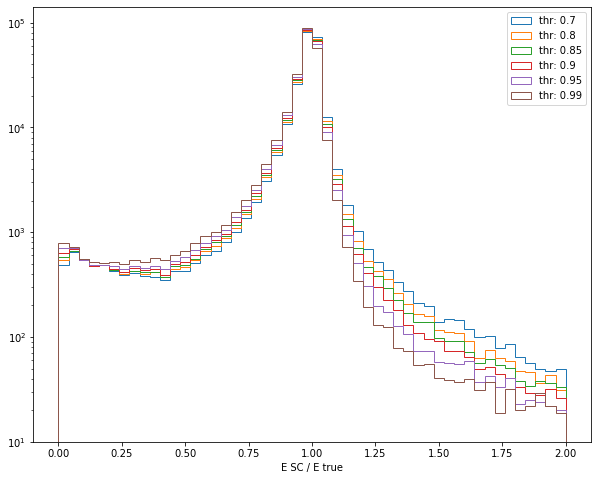

In [61]:
for t , g in results.items():
    plt.hist(g.ratio, range=(0,2), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

In [62]:
for t , g in results.items():
    print(f"threshold: {t}, RMS: {g.ratio.std()}")

threshold: 0.7, RMS: 33.123284133939286
threshold: 0.8, RMS: 33.07314358909168
threshold: 0.85, RMS: 32.927792051407124
threshold: 0.9, RMS: 32.90931068140383
threshold: 0.95, RMS: 32.59652685847742
threshold: 0.99, RMS: 32.49030729030025
